In [1]:
from policies.state_value_nn import NNValueFn
from policies.state_value_linear import LinearValueFn
from policies.state_value_conv import ConvNNValueFn
from policies.nn_fit import NNFitPolicy
from page import Page
from environments.single_state_env import SingleStateEnv
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


#Based on sutton and barto pseudo code
def semi_gradient_n_step_td(
    env, #open-ai environment
    gamma:float,
    pi:NNFitPolicy,
    n:int,
    alpha:float,
    V:NNValueFn,
    num_episode:int,
    evaluate:bool = False
):
    """
    implement n-step semi gradient TD for estimating v

    input:
        env: target environment
        gamma: discounting factor
        pi: target evaluation policy
        n: n-step
        alpha: learning rate
        V: value function
        num_episode: #episodes to iterate
    output:
        None
    """

    all_returns = []
    action_count_per_ep = []
    losses_per_ep = []
    for ep in tqdm(range(num_episode)):
        cap_T = float('inf')
        tau = -1
        t = 0

        rewards = []
        states = []
        losses = []
        state,  done = env.reset()
        acc_r = 0.
        states.append(state['pages'][0])
        rewards.append(acc_r)
        
        action_count = [0] * 3
        while tau < cap_T:
            if t < cap_T:
                rq = state["rq"]
                if rq[0] == 0:
                    state, r, done, = env.step([rq[0], rq[1]])
                else:
                    a = pi.action(state)
                    action_idx = a[2]
                    action_count[action_idx] += 1
                    a = (a[0], a[1])
                    state, r, done,  = env.step(a)
                states.append(state['pages'][0])
                rewards.append(r)
                if done:
                    cap_T = t + 1
                
            tau = t - n + 1
            if tau >= 0:    
                sum_end = min(tau + n, cap_T)
                i = tau + 1
                G = 0
                while i <= sum_end:
                    G += (gamma ** (i - tau - 1) * rewards[i])
                    i += 1
                if tau + n < cap_T:
                    G = G + (gamma ** (n)) * V(states[tau + n])
                    if np.array_equal(states[tau + n].bitmap, states[tau].bitmap):
                        print("EQUAL ARRAYS")
                #print(f"episode {ep}: G = {G}")
                losses.append(V.update(alpha, G, states[tau]))
                #break
            t += 1
        #print(f"episode {ep}: {sum(rewards)}")
        all_returns.append(sum(rewards))
        action_count_per_ep.append(action_count)
        losses_per_ep.append(np.mean(losses))

    action_count_per_ep = np.array(action_count_per_ep)
    #plot returns for each episode
    return all_returns, action_count_per_ep, losses_per_ep

In [2]:
gamma = 1.
page_size = 50
num_episodes = 2000
env = SingleStateEnv(page_size=page_size, allocator="ff_bad")
V = NNValueFn(page_size)
#V = ConvNNValueFn(page_size)
#V = LinearValueFn()
policy = NNFitPolicy(V)

<class 'request_streams.ff_bad.FFBad'>


In [3]:
all_returns, action_count_per_ep, losses_per_ep = semi_gradient_n_step_td(env,1.,policy,1,0.001,V,num_episodes, evaluate=False) #train
#all_returns, action_count_per_ep, losses_per_ep = semi_gradient_n_step_td(env,1.,policy,1,0.001,V,num_episodes, evaluate=True) #train

In [4]:
last_100 = action_count_per_ep[-100:]
last_100_avg_cnts = np.average(last_100, axis=0)

first_10 = action_count_per_ep[:1]
first_10_avg_cnts = np.average(first_10, axis=0)

plt.bar(np.arange(3), first_10_avg_cnts)
plt.title("Action count for first 10 episodes")
plt.xticks(np.arange(3), ["best fit", "worst fit", "first fit"])

#plot as barplot
plt.figure()
plt.bar(np.arange(3), last_100_avg_cnts)
plt.title("Action count for last 100 episodes")



#1 is best fit, 2 is worst fit, 3 is first fit
plt.xticks(np.arange(3), ["best fit", "worst fit", "first fit"])


plt.figure()
plt.plot(losses_per_ep)
plt.title("Losses per episode")

#plot returns, along with an for the last 100 episodes
avg = np.average(all_returns[-100:])
print(f"Policy : {avg}")
plt.figure()
plt.plot(all_returns)
plt.hlines(avg, 0, num_episodes, colors='r', linestyles='dashed')
plt.title(f"Policy returns")
plt.xlabel("episode")
plt.ylabel("return")


NameError: name 'action_count_per_ep' is not defined

In [5]:
gamma = 1.
page_size = 50
num_episodes = 2000
env = SingleStateEnv(page_size=page_size, allocator="ff_bad")
#V = NNValueFn(page_size)
V = ConvNNValueFn(page_size)
#V = LinearValueFn()
policy = NNFitPolicy(V)

<class 'request_streams.ff_bad.FFBad'>


c:\Users\lawso\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
all_returns, action_count_per_ep, losses_per_ep = semi_gradient_n_step_td(env,1.,policy,1,0.001,V,num_episodes, evaluate=False) #train

  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\lawso\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 2/2000 [00:00<01:49, 18.23it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape to

  0%|          | 9/2000 [00:00<01:18, 25.50it/s]

(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape to

  1%|          | 12/2000 [00:00<01:24, 23.42it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape to

  1%|          | 15/2000 [00:00<01:25, 23.26it/s]

(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1,

  1%|          | 18/2000 [00:00<01:24, 23.52it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  1%|          | 21/2000 [00:00<01:18, 25.18it/s]

(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape to

  1%|▏         | 27/2000 [00:01<01:25, 23.20it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape to

  2%|▏         | 30/2000 [00:01<01:24, 23.29it/s]

x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1,

  2%|▏         | 35/2000 [00:01<01:13, 26.72it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape to

  2%|▏         | 40/2000 [00:01<01:08, 28.54it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape to

  2%|▏         | 43/2000 [00:01<01:22, 23.85it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1,

  2%|▏         | 46/2000 [00:01<01:19, 24.69it/s]

x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1,

  2%|▎         | 50/2000 [00:02<01:16, 25.33it/s]

x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  3%|▎         | 53/2000 [00:02<01:19, 24.61it/s]

(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  3%|▎         | 56/2000 [00:02<01:32, 20.94it/s]

x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])


  3%|▎         | 59/2000 [00:02<01:27, 22.18it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  3%|▎         | 63/2000 [00:02<01:20, 23.97it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1,

  3%|▎         | 67/2000 [00:02<01:13, 26.16it/s]

(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1,

  4%|▎         | 70/2000 [00:02<01:22, 23.34it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  4%|▎         | 73/2000 [00:03<01:18, 24.53it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  4%|▍         | 76/2000 [00:03<01:14, 25.74it/s]

x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])


  4%|▍         | 80/2000 [00:03<01:07, 28.25it/s]

x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  4%|▍         | 83/2000 [00:03<01:22, 23.35it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1,

  4%|▍         | 86/2000 [00:03<01:26, 22.00it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape to

  4%|▍         | 90/2000 [00:03<01:20, 23.69it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Si

  5%|▍         | 93/2000 [00:03<01:18, 24.18it/s]

x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Si

  5%|▍         | 96/2000 [00:03<01:19, 23.97it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])


  5%|▌         | 100/2000 [00:04<01:19, 23.77it/s]

(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
(50,)
x.shape torch.Size([1, 50])
x.shape torch.Size([1, 50])
(50,)
x.shape to

KeyboardInterrupt: 

In [ ]:
last_100 = action_count_per_ep[-100:]
last_100_avg_cnts = np.average(last_100, axis=0)

first_10 = action_count_per_ep[:1]
first_10_avg_cnts = np.average(first_10, axis=0)

plt.bar(np.arange(3), first_10_avg_cnts)
plt.title("Action count for first 10 episodes")
plt.xticks(np.arange(3), ["best fit", "worst fit", "first fit"])

#plot as barplot
plt.figure()
plt.bar(np.arange(3), last_100_avg_cnts)
plt.title("Action count for last 100 episodes")



#1 is best fit, 2 is worst fit, 3 is first fit
plt.xticks(np.arange(3), ["best fit", "worst fit", "first fit"])


plt.figure()
plt.plot(losses_per_ep)
plt.title("Losses per episode")

#plot returns, along with an for the last 100 episodes
avg = np.average(all_returns[-100:])
print(f"Policy : {avg}")
plt.figure()
plt.plot(all_returns)
plt.hlines(avg, 0, num_episodes, colors='r', linestyles='dashed')
plt.title(f"Policy returns")
plt.xlabel("episode")
plt.ylabel("return")


Compare to baselines

In [ ]:
from allocators.best_fit_allocator import BestFitAllocator
from allocators.worst_fit_allocator import WorstFitAllocator
from allocators.first_fit_allocator import FirstFitAllocator

all_returns = {}
allocators = [BestFitAllocator(), WorstFitAllocator(), FirstFitAllocator()]
for allocator in allocators:
    curr_allocator_return = []
    for ep in tqdm(range(num_episodes)):
        s, done = env.reset()
        r = -1

        count = 0
        rewards = []
        while not done:
            #ac is mem_addr_or_amt
            curr_page = s["pages"][0]
            if s["rq"][0] == 0:
                ac = s["rq"][1]
            else:
                ac = allocator.handle_alloc_req(s["pages"], s["rq"][1])[1]

            s,r,done = env.step([s["rq"][0], ac])
            rewards.append(r)
            # print("Current page's resulting free list: ", curr_page.free_list, "Current page's resulting allocated list: ", curr_page.allocated_list)
            # print("----------------------------------")
            count += 1
        curr_allocator_return.append(sum(rewards))
    all_returns[type(allocator).__name__] = curr_allocator_return

100%|██████████| 2000/2000 [00:01<00:00, 1130.44it/s]


BestFitAllocator 95% conf int: 40.14 +- 29.629046559077796
WorstFitAllocator 95% conf int: 8.97 +- 4.290582711007912
FirstFitAllocator 95% conf int: 9.38 +- 4.16120174949497


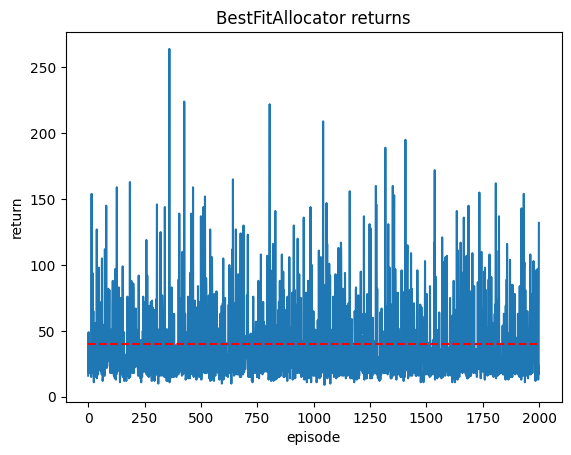

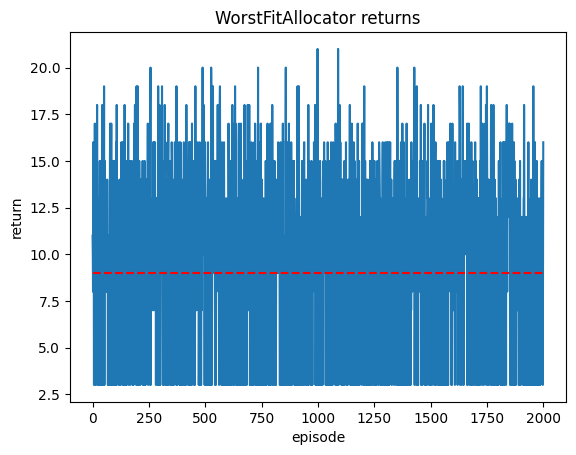

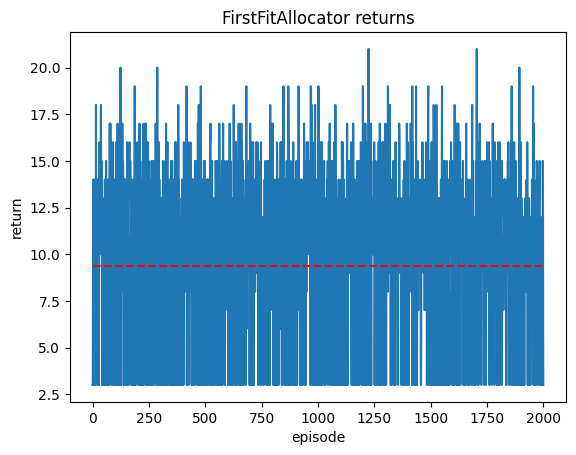

In [ ]:
#plot returns
for name, returns in all_returns.items():
    avg = np.average(returns[-100:])
    std = np.std(returns[-100:])
    print(f"{name} 95% conf int: {avg} +- {std}")
    plt.figure()
    plt.plot(returns, label=name)
    plt.hlines(avg, 0, num_episodes, colors='r', linestyles='dashed')
    plt.title(f"{name} returns")
    plt.xlabel("episode")
    plt.ylabel("return")

